In [5]:
%matplotlib widget
import importlib
import numpy as np
import matplotlib.pyplot as mpl
import RingdownFitting as rd
import time

# Example code for running ringdown fits.

## Keyword arguments for "fit_single_ringdown":
- f_fit_iter (_default val 0_): Number of times to perform software lockin, phase fit, and update the frequency before moving on to amplitude fit.
- method (_default 'logfit'_): Method for fitting the amplitude
- decimation (_default 50_): how much to downsample when performing software lockin
- harmonics (_default 10_): How many harmonics to calculate during software lockin, used to make the THD calculation
- startbuff (_default 0.01_): what fraction of data to throw out at the start of the timestream
- endbuff (_default 0.01_): what fraction of data to throw out at the end of the timestream (trumped by cutoffs from detuning and THD)
- minPhiSamples (_default 10_): minimum number of phase data points to use in the fit
- max_expected_detuning (_default 20000_): maximum jump between points allowed in phase fit
- max_THD (_default 10_): maximum value of total harmonic distortion allowed in amplitude fit. THD is defined as $\frac{\sqrt{\sum_n (r^2(nf_0))}}{r(f_0)}$ where $r(nf_0)$ is the amplitude at the $n$th harmonic of the lockin frequency. It's a bit of a hack to use this as a proxy for low SNR data cutoff... but it works
- start_max_THD (_defaults to max_THD_): separate cutoff used for the start of amplitude data in the fit. Useful to set tight value for this (~0.5 or below) to eliminate transient higher harmonics at the start of a ringdown due to transient effects.
- printThings (_default TRUE_): allow print outputs
- showPLTs (_default TRUE_): allow plots to be shown

## Let's generate some example data

To demonstrate the fitting code, let's make some fake ringdown data by multiplying a sine wave by an exponential decay with time constant $\tau$. Here, I've arbitrarily picked a frequency of 670.123 kHz and a Q of 136. I've also added some gaussian noise.

In [138]:
f = 670.123e3
Q = 136
tau = Q/(f*np.pi)
samplerate = 50e6
ts = 2e-4

t = np.linspace(0, ts, int(samplerate*ts))
amp = np.sin(2*np.pi*f*t+np.pi/17)*(np.exp(-1*t/tau))+0.05*np.random.randn(len(t))

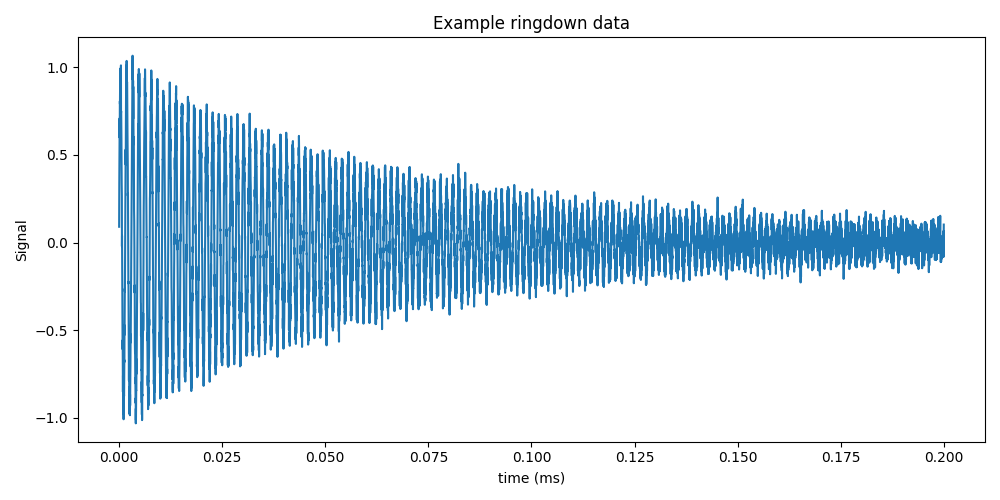

In [139]:
fig, ax = mpl.subplots(figsize=(10,5))
ax.plot(t*1e3, amp)
ax.set_ylabel('Signal')
ax.set_xlabel('time (ms)')
ax.set_title('Example ringdown data')
fig.tight_layout()

Fitted phase iter 0 using 91 points, freq = 670169.31
Fitting log(amplitude) with linear fit and 197 points
Fitted values: Q = 135.81645130149812, F = 670169.3141244529
Q fitted with 0.13% error
Freq fitted with 0.0069112871% error


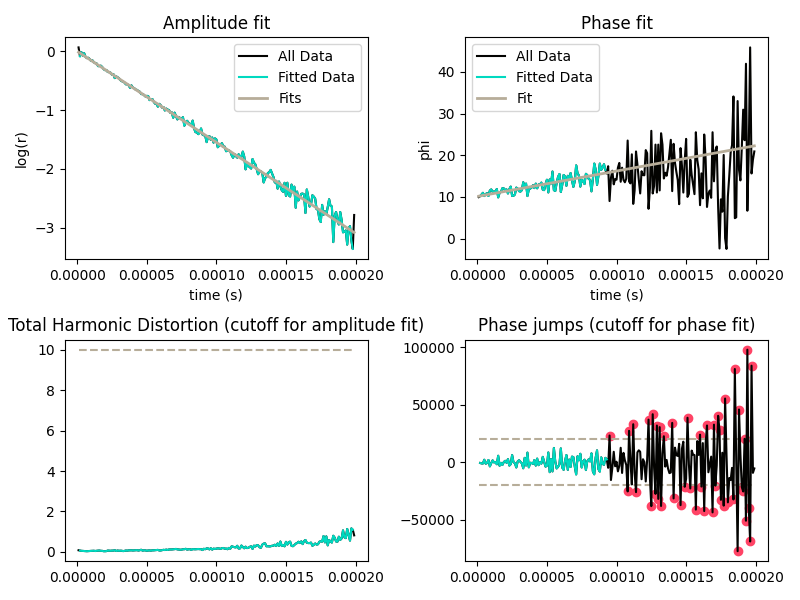

In [141]:
importlib.reload(rd)
Q_fit, F_fit = rd.fit_single_ringdown(t, amp, 670e3, decimation=20, method='logfit', startbuff = 0, endbuff = 0)
print(f'Fitted values: Q = {Q_fit}, F = {F_fit}')
print(f'Q fitted with {100*np.abs(Q_fit-Q)/Q:.2f}% error')
print(f'Freq fitted with {100*np.abs(F_fit-f)/f:.10f}% error')

## Ok-- first results.

The fit does pretty well! Now, some caveats-- we've only sampled when there is relatively good SNR, before the signal disappears into the noise floor. Let's try with a "longer" timestream, and see if we can use more of the low SNR data. for now, we'll set the THD cutoff unreasonably high to try and use even the "bad" data.

In [142]:
f = 670.123e3
Q = 136
tau = Q/(f*np.pi)
samplerate = 50e6
ts = 5e-4

t = np.linspace(0, ts, int(samplerate*ts))
amp = 2*np.sin(2*np.pi*f*t+np.pi/17)*(np.exp(-1*t/tau))+0.2*np.random.randn(len(t))

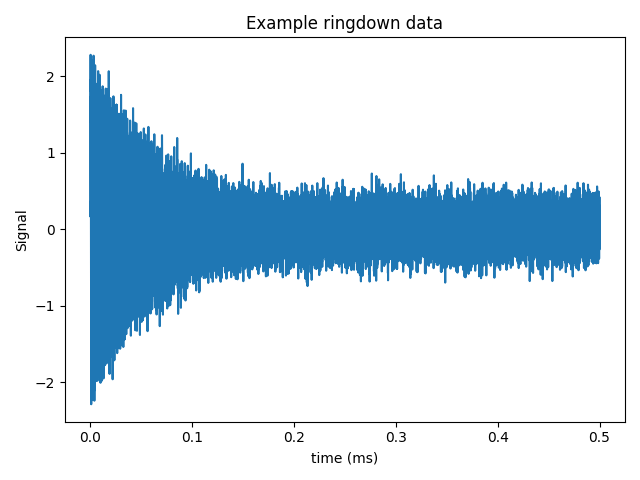

In [143]:
fig, ax = mpl.subplots()
ax.plot(t*1e3, amp)
ax.set_ylabel('Signal')
ax.set_xlabel('time (ms)')
ax.set_title('Example ringdown data')
fig.tight_layout()

Fitted phase iter 0 using 65 points, freq = 670083.53
Fitting log(amplitude) with linear fit and 497 points
Fitted values: Q = 276.0029457848269, F = 670083.5257834004
Q fitted with 102.94% error
Freq fitted with 0.0058905927% error


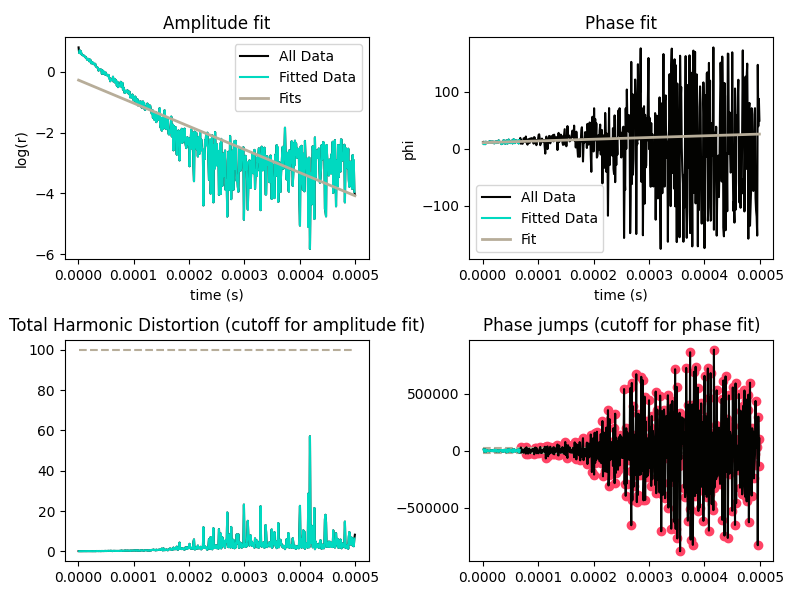

In [144]:
Q_fit, F_fit = rd.fit_single_ringdown(t, amp, 670e3, decimation=20, method='logfit', startbuff = 0, endbuff = 0, max_THD = 100)
print(f'Fitted values: Q = {Q_fit}, F = {F_fit}')
print(f'Q fitted with {100*np.abs(Q_fit-Q)/Q:.2f}% error')
print(f'Freq fitted with {100*np.abs(F_fit-f)/f:.10f}% error')


# Hmm... the Q fit is terrible!

## But!

There's another option-- switch the fitting method to "exp_floor". This is a slightly more computationally intensive fit, because we are fitting to a more complicated exponential decay into a floor. Let's still leave the THD cutoff out of it and try to fit the whole timestream.

Fitted phase iter 0 using 110 points, freq = 670125.30
Fitting amplitude using exponential fit with floor and 497 points
Fitted values: Q = 129.25177165260882, F = 670125.2956277549
Q fitted with 4.96% error
Freq fitted with 0.0003425681% error


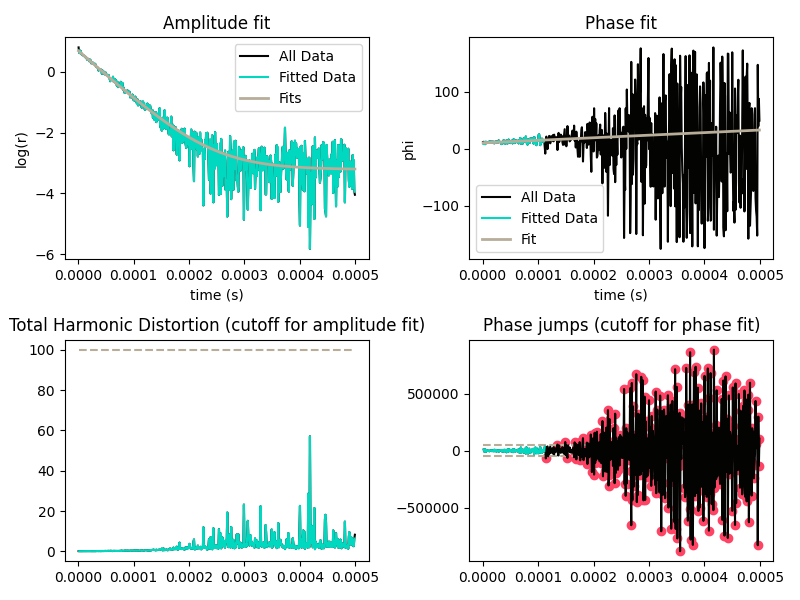

In [145]:
importlib.reload(rd)
Q_fit, F_fit = rd.fit_single_ringdown(t, amp, 670e3, decimation=20, method='exp_floor', startbuff = 0, endbuff = 0, max_expected_detuning = 50000, max_THD=100)
print(f'Fitted values: Q = {Q_fit}, F = {F_fit}')
print(f'Q fitted with {100*np.abs(Q_fit-Q)/Q:.2f}% error')
print(f'Freq fitted with {100*np.abs(F_fit-f)/f:.10f}% error')

## Ok! That's better! 6% error is...ok, and we can do even better by setting appropriate THD cutoffs.

Fitted phase iter 0 using 110 points, freq = 670125.30
Fitting amplitude using exponential fit with floor and 175 points
Fitted values: Q = 135.76270170590232, F = 670125.2956277549
Q fitted with 0.17% error
Freq fitted with 0.0003425681% error


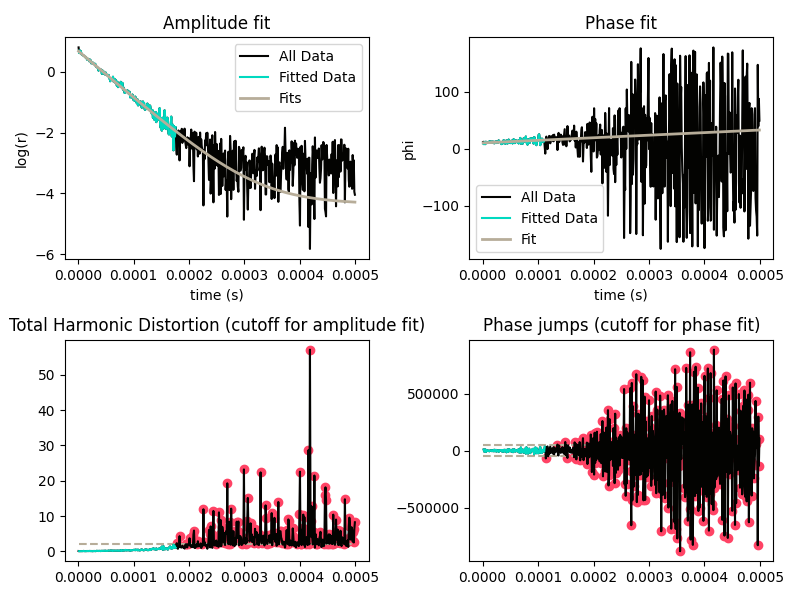

In [146]:
importlib.reload(rd)
Q_fit, F_fit = rd.fit_single_ringdown(t, amp, 670e3, decimation=20, method='exp_floor', startbuff = 0, endbuff = 0, max_expected_detuning = 50000, max_THD=2)
print(f'Fitted values: Q = {Q_fit}, F = {F_fit}')
print(f'Q fitted with {100*np.abs(Q_fit-Q)/Q:.2f}% error')
print(f'Freq fitted with {100*np.abs(F_fit-f)/f:.10f}% error')

## Now let's make some absolutely terrible data:

Th logfit actually works better for this one. We can still get the Q within 5%!

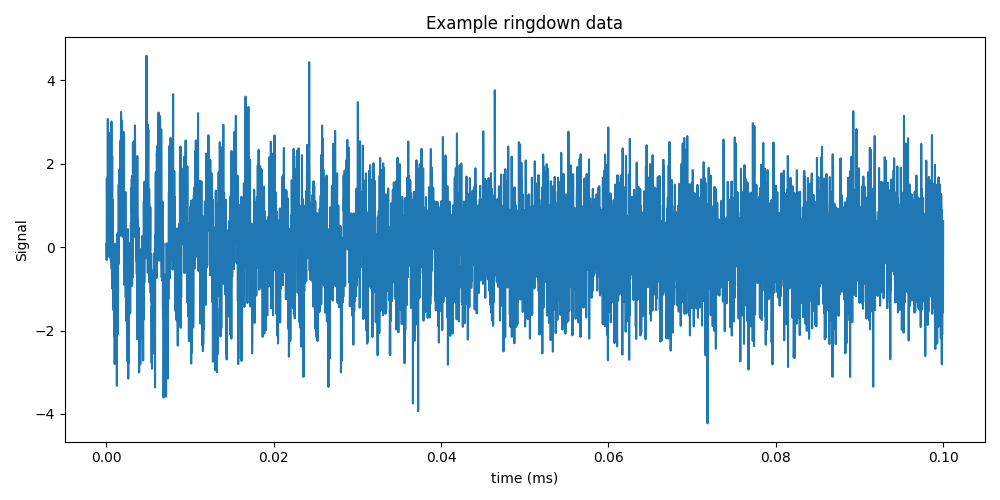

In [155]:
f = 670.123e3
Q = 50
tau = Q/(f*np.pi)
samplerate = 50e6
ts = 1e-4

t = np.linspace(0, ts, int(samplerate*ts))
amp = 2*np.sin(2*np.pi*f*t+np.pi/17)*(np.exp(-1*t/tau))+np.random.randn(len(t))

fig, ax = mpl.subplots(figsize=(10,5))
ax.plot(t*1e3, amp)
ax.set_ylabel('Signal')
ax.set_xlabel('time (ms)')
ax.set_title('Example ringdown data')
fig.tight_layout()

Fitted phase iter 0 using 21 points, freq = 668979.02
Fitting log(amplitude) with linear fit and 45 points
Fitted values: Q = 52.15669213949143, F = 668979.0205849211
Q fitted with 4.31% error
Freq fitted with 0.1707118566% error


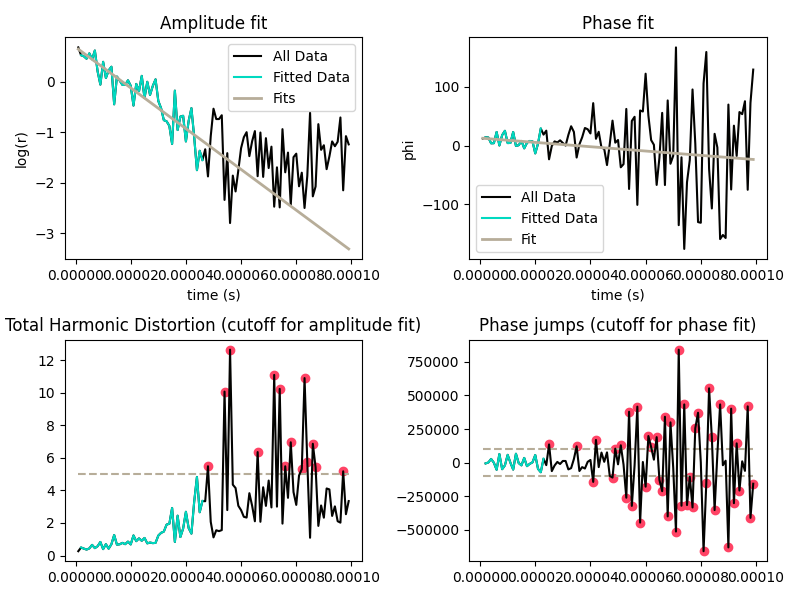

In [164]:
importlib.reload(rd)
Q_fit, F_fit = rd.fit_single_ringdown(t, amp, 670e3, f_fit_iter = 1, decimation=50, method='logfit', startbuff = 0, endbuff = 0, max_expected_detuning = 100000, max_THD=5)
print(f'Fitted values: Q = {Q_fit}, F = {F_fit}')
print(f'Q fitted with {100*np.abs(Q_fit-Q)/Q:.2f}% error')
print(f'Freq fitted with {100*np.abs(F_fit-f)/f:.10f}% error')

## Now trying to deal with saturation effects:

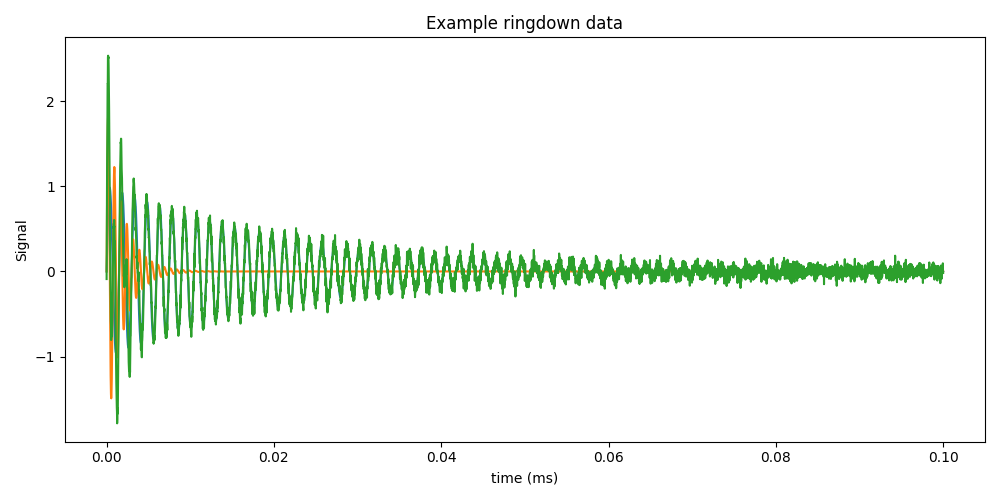

In [202]:
f = 670.123e3
Q1 = 1720
Q2 = 8
tau = Q/(f*np.pi)
tau2 = Q2/(2*f*np.pi)
samplerate = 50e6
ts = 1e-4

t = np.linspace(0, ts, int(samplerate*ts))
amp1 = np.sin(2*np.pi*f*t)*(np.exp(-1*t/tau))
amp2 = 2*np.sin(4*np.pi*f*t)*(np.exp(-1*t/tau2))
amp = amp1+amp2 + 0.05*np.random.randn(len(t))

fig, ax = mpl.subplots(figsize=(10,5))
ax.plot(t*1e3, amp1)
ax.plot(t*1e3, amp2)
ax.plot(t*1e3, amp)
ax.set_ylabel('Signal')
ax.set_xlabel('time (ms)')
ax.set_title('Example ringdown data')
fig.tight_layout()

Fitted phase iter 0 using 79 points, freq = 669863.42
Fitting log(amplitude) with linear fit and 68 points
Fitted values: Q = 50.94499924732825, F = 669863.4225201085
Q fitted with 1.89% error
Freq fitted with 0.0387357962% error


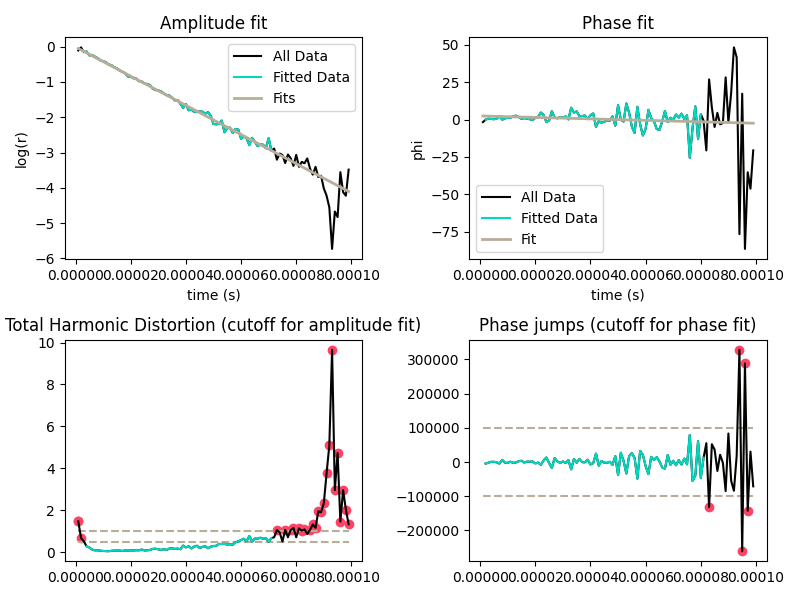

In [201]:
importlib.reload(rd)
Q_fit, F_fit = rd.fit_single_ringdown(t, amp, 670e3, f_fit_iter = 1, decimation=10, method='logfit', startbuff = 0, endbuff = 0, max_expected_detuning = 100000, start_max_THD=0.5, max_THD=1)
print(f'Fitted values: Q = {Q_fit}, F = {F_fit}')
print(f'Q fitted with {100*np.abs(Q_fit-Q)/Q:.2f}% error')
print(f'Freq fitted with {100*np.abs(F_fit-f)/f:.10f}% error')